In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import sys
import time
from collections import namedtuple, defaultdict
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random
import cPickle as pickle

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model

import logging
from logging import info


import keras
from keras.layers import Input, Dense, Dropout, Masking
from keras.models import Model, Sequential
from keras.layers import Input, Masking
from keras.layers.convolutional import MaxPooling1D, Convolution1D
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.recurrent import LSTM

from sklearn.model_selection import ParameterSampler

from thesis.utils.metrics import *
from thesis.utils.file import *
from thesis.utils.classification import *

Using Theano backend.
Using gpu device 0: TITAN X (Pascal) (CNMeM is disabled, cuDNN 5105)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [3]:
RANDOM_SEED = 10000
NN_SEED = 1234
random.seed(RANDOM_SEED)

MAX_TERMS = 10000

In [4]:
NUM_CORES = 16

In [5]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL_NAME', 'DOC2VEC_MODEL', 
                                         'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [6]:
NN_PARAMETER_SEARCH_PREFIX = "nn_lda_{}_batch_{}_nn_parameter_searches.pkl"

In [7]:
root_location = "/mnt/data2/shalaby/"
exports_location = root_location + "exported_data/"
lda_location = "/mnt/data/shalaby/" + "extended_pv_lda/"

nn_parameter_search_location = os.path.join(root_location, "nn_lda_parameter_search")

training_file = root_location + "docs_output.json"

classifications_index_file = exports_location + "classifications_index.pkl"
doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
valid_classes_file = exports_location + "valid_classes.pkl"
valid_subclasses_file = exports_location + "valid_subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
training_docs_list_file = exports_location + "training_docs_list.pkl"
validation_docs_list_file = exports_location + "validation_docs_list.pkl"
test_docs_list_file = exports_location + "test_docs_list.pkl"

In [8]:
def create_keras_rnn_model(input_size, output_size, lstm_output_size, w_dropout_do, u_dropout_do, 
                           stack_layers=1, conv_size=None, conv_filter_length=3, max_pooling_length=None):
    
    model= Sequential()
#     model.add(Masking(mask_value=0., input_shape=(MAX_SIZE, input_size)))
    if conv_size:
        model.add(Convolution1D(nb_filter=conv_size, input_shape=(MAX_SIZE, input_size), filter_length=conv_filter_length, 
                                border_mode='same', activation='relu'))
        if max_pooling_length is not None:
            model.add(MaxPooling1D(pool_length=max_pooling_length))
    for i in range(stack_layers):
        model.add(LSTM(lstm_output_size, input_dim=input_size, dropout_W=w_dropout_do, dropout_U=u_dropout_do,
                       return_sequences=False if i+1 == stack_layers else True,
                  name='lstm_{}_w-drop_{}_u-drop_{}_layer_{}'.format(lstm_output_size, str(u_dropout_do), str(w_dropout_do), str(i+1))))
    model.add(Dense(output_size, activation='sigmoid', name='sigmoid_output'))
    model.compile(optimizer=NN_OPTIMIZER, loss='binary_crossentropy')
    return model

In [9]:
%%time
doc_classification_map = pickle.load(open(doc_classifications_map_file))
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
valid_classes = pickle.load(open(valid_classes_file))
valid_subclasses = pickle.load(open(valid_subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))
test_docs_list = pickle.load(open(test_docs_list_file))

CPU times: user 20 s, sys: 1.78 s, total: 21.8 s
Wall time: 21.7 s


In [10]:
early_stopper_deltas = {
    'sections': 0.00001,
    'classes': 0.00001,
    'subclasses': 0.00001
}
early_stopper_patience = {
    'sections': 15,
    'classes': 15,
    'subclasses': 15
}
epochs_before_validation = {
    'sections': 5,
    'classes': 20,
    'subclasses': 20
}

# ranges for learning graph shown
metrics_graph_ranges = {
    'sections': {'min':0, 'max': 0.5},
    'classes': {'min':0, 'max': 0.05},
    'subclasses': {'min':0, 'max': 0.05}
}

In [11]:
class MetricsCallbackWithGenerator(keras.callbacks.Callback):
    """
    Callback called by keras after each epoch. Records the best validation loss and periodically checks the 
    validation metrics
    """
    def __init__(self):
        MetricsCallbackWithGenerator.EPOCHS_BEFORE_VALIDATION = epochs_before_validation[classifications_type]
        MetricsCallbackWithGenerator.GRAPH_MIN = metrics_graph_ranges[classifications_type]['min']
        MetricsCallbackWithGenerator.GRAPH_MAX = metrics_graph_ranges[classifications_type]['max']
    
    def on_train_begin(self, logs={}):
        self.epoch_index = 0
        self.val_loss_reductions = 0
        self.metrics_dict = {}
        self.best_val_loss = np.iinfo(np.int32).max
        self.best_weights = None
        self.best_validation_metrics = None
        
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure(figsize=(12,6), dpi=80)
        self.ax = plt.subplot(111)
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_index += 1
        self.losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])
        loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.losses, 'g-', label='Training Loss')
        val_loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.val_losses, 'r-', label='Validation Loss')
        self.ax.legend(handles=[loss_line, val_loss_line])
        self.ax.set_ylim((MetricsCallbackWithGenerator.GRAPH_MIN, MetricsCallbackWithGenerator.GRAPH_MAX))
        self.fig.canvas.draw()
        if logs['val_loss'] < self.best_val_loss:
            self.val_loss_reductions += 1
            self.best_val_loss = logs['val_loss']
            self.best_weights = self.model.get_weights()
            #print '\r    \r' # to remove the previous line of verbose output of model fit
            #time.sleep(0.1)
            info('Found lower val loss for epoch {} => {}'.format(self.epoch_index, round(logs['val_loss'], 5)))
            if self.val_loss_reductions % MetricsCallbackWithGenerator.EPOCHS_BEFORE_VALIDATION == 0:
                
                info('Validation Loss Reduced {} times'.format(self.val_loss_reductions))
                info('Evaluating on Validation Data')
                yvp = self.model.predict_generator(generator=nn_batch_generator_reshaper(Xv, yv, NN_BATCH_SIZE), 
                                                   val_samples=Xv.shape[0])
                yvp_binary = get_binary_0_5(yvp)
                info('Generating Validation Metrics')
                validation_metrics = get_metrics(yv, yvp, yvp_binary)
                print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
                    validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
                    validation_metrics['f1_micro'], validation_metrics['f1_macro'])
                self.metrics_dict[self.epoch_index] = validation_metrics
#                 self.best_validation_metrics = validation_metrics

In [12]:
def nn_batch_generator_reshaper(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter = 0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
#         X_batch = X_data[index_batch,:].todense()
        X_batch = X_data[index_batch,:]
        X_batch = X_batch.reshape((X_batch.shape[0], 1, X_batch.shape[1]))
        y_batch = y_data[index_batch]
        counter += 1
        yield X_batch,y_batch
        if (counter > number_of_batches):
            counter=0

## Global Param Loop

In [13]:
LDA_TOPICS = 1000
LDA_ITERATIONS = 50
LDA_BATCH_SIZE = 4096
LDA_DECAY = 0.5
LDA_EVALUATE_EVERY = 1000
LDA_VERBOSE = 2
LDA_LEARNING_METHOD = 'online'
LDA_MODEL_NAME = "lda_{}_topics_{}_iter_{}_batch_{}_decay_{}_evaluate-every_{}".format(LDA_LEARNING_METHOD, 
                                                                                       LDA_TOPICS, LDA_ITERATIONS,
                                                                                       LDA_BATCH_SIZE, LDA_DECAY, 
                                                                                       LDA_EVALUATE_EVERY)

In [14]:
data_type = "bm25"

In [15]:
GLOBAL_PARMS_TO_RUN = [
#     {
#         'data_type': data_type,
#         'classifications': sections,
#         'classifications_type': 'sections',
#         'nn_batch_size': 2048,
#         'lstm_output_size': 500,
#         'lstm_w_dropout': 0.5,
#         'lstm_u_dropout': 0.5,
#         'lstm_stack_layers': 1,
#         'lstm_conv_size': None,
#         'lstm_conv_filter_length': None ,
#         'lstm_max_pooling_length': None
#     },
#     {
#         'data_type': data_type,
#         'classifications': sections,
#         'classifications_type': 'sections',
#         'nn_batch_size': 2048,
#         'lstm_output_size': 1000,
#         'lstm_w_dropout': 0.5,
#         'lstm_u_dropout': 0.5,
#         'lstm_stack_layers': 1,
#         'lstm_conv_size': None,
#         'lstm_conv_filter_length': None ,
#         'lstm_max_pooling_length': None
#     },
#     {
#         'data_type': data_type,
#         'classifications': valid_classes,
#         'classifications_type': 'classes',
#         'nn_batch_size': 2048,
#         'lstm_output_size': 500,
#         'lstm_w_dropout': 0.5,
#         'lstm_u_dropout': 0.5,
#         'lstm_stack_layers': 1,
#         'lstm_conv_size': None,
#         'lstm_conv_filter_length': None ,
#         'lstm_max_pooling_length': None
#     },
#     {
#         'data_type': data_type,
#         'classifications': valid_classes,
#         'classifications_type': 'classes',
#         'nn_batch_size': 2048,
#         'lstm_output_size': 1000,
#         'lstm_w_dropout': 0.5,
#         'lstm_u_dropout': 0.5,
#         'lstm_stack_layers': 1,
#         'lstm_conv_size': None,
#         'lstm_conv_filter_length': None ,
#         'lstm_max_pooling_length': None
#     },
#     {
#         'data_type': data_type,
#         'classifications': valid_subclasses,
#         'classifications_type': 'subclasses',
#         'nn_batch_size': 2048,
#         'lstm_output_size': 500,
#         'lstm_w_dropout': 0.5,
#         'lstm_u_dropout': 0.5,
#         'lstm_stack_layers': 1,
#         'lstm_conv_size': None,
#         'lstm_conv_filter_length': None ,
#         'lstm_max_pooling_length': None
#     },
    {
        'data_type': data_type,
        'classifications': valid_subclasses,
        'classifications_type': 'subclasses',
        'nn_batch_size': 2048,
        'lstm_output_size': 1000,
        'lstm_w_dropout': 0.5,
        'lstm_u_dropout': 0.5,
        'lstm_stack_layers': 1,
        'lstm_conv_size': None,
        'lstm_conv_filter_length': None ,
        'lstm_max_pooling_length': None
    },
]


==================================== NEW PARAM SET ============================================
{'lstm_conv_filter_length': None, 'lstm_stack_layers': 1, 'nn_batch_size': 2048, 'classifications_type': 'subclasses', 'lstm_w_dropout': 0.5, 'data_type': 'bm25', 'lstm_max_pooling_length': None, 'lstm_u_dropout': 0.5, 'lstm_output_size': 1000, 'lstm_conv_size': None}


2017-04-11 11:56:03,173 : INFO : Getting Training Data


CPU times: user 14min 19s, sys: 6min 15s, total: 20min 35s
Wall time: 23min 54s
CPU times: user 1min 40s, sys: 27.7 s, total: 2min 7s
Wall time: 13min 7s
(1286325, 1000)
(1286325, 940)


2017-04-11 12:50:18,925 : INFO : Getting Validation Data


CPU times: user 3min 33s, sys: 22.2 s, total: 3min 55s
Wall time: 3min 55s


2017-04-11 12:56:08,059 : INFO : Loading Previous results from /mnt/data2/shalaby/nn_lda_parameter_search/bm25/size_10000/nn_lda_subclasses_batch_2048_nn_parameter_searches.pkl


CPU times: user 16 s, sys: 1.91 s, total: 17.9 s
Wall time: 1min 53s
(321473, 1000)
(321473, 940)


2017-04-11 12:56:09,463 : INFO : ***************************************************************************************
2017-04-11 12:56:09,464 : INFO : lstm_optimizer_rmsprop_size_1000_w-drop_0.5_u-drop_0.5_stack_1_conv_None


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1000_w-drop_0.5_u-drop_0.5_ (None, 1000)          8004000     lstm_input_1[0][0]               
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 940)           940940      lstm_1000_w-drop_0.5_u-drop_0.5_l
Total params: 8944940
____________________________________________________________________________________________________


<IPython.core.display.Javascript object>


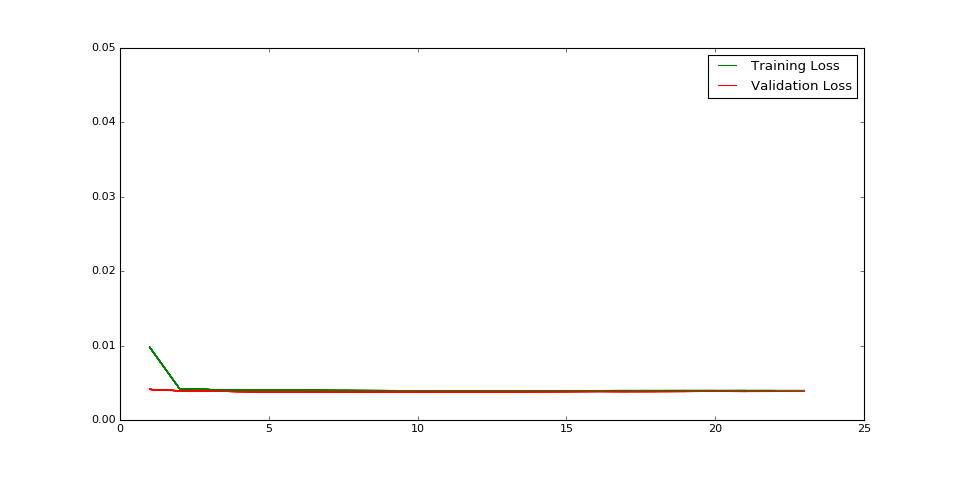

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0098

2017-04-11 12:57:52,056 : INFO : Found lower val loss for epoch 1 => 0.00411


1286325/1286325 [==============================] - 73s - loss: 0.0098 - val_loss: 0.0041
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-11 12:59:03,949 : INFO : Found lower val loss for epoch 2 => 0.00393


1286325/1286325 [==============================] - 71s - loss: 0.0042 - val_loss: 0.0039
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0041

2017-04-11 13:00:16,069 : INFO : Found lower val loss for epoch 3 => 0.00386


1286325/1286325 [==============================] - 72s - loss: 0.0041 - val_loss: 0.0039
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-11 13:01:27,733 : INFO : Found lower val loss for epoch 4 => 0.00383


1286325/1286325 [==============================] - 71s - loss: 0.0040 - val_loss: 0.0038
Epoch 5/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-11 13:02:40,814 : INFO : Found lower val loss for epoch 5 => 0.00381


1286325/1286325 [==============================] - 73s - loss: 0.0040 - val_loss: 0.0038
Epoch 6/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-11 13:03:52,752 : INFO : Found lower val loss for epoch 6 => 0.00379


1286325/1286325 [==============================] - 71s - loss: 0.0040 - val_loss: 0.0038
Epoch 7/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-11 13:05:04,726 : INFO : Found lower val loss for epoch 7 => 0.00378


1286325/1286325 [==============================] - 71s - loss: 0.0040 - val_loss: 0.0038
Epoch 8/200
1286325/1286325 [==============================] - 72s - loss: 0.0040 - val_loss: 0.0038
Epoch 9/200
1286325/1286325 [==============================] - 73s - loss: 0.0040 - val_loss: 0.0038
Epoch 10/200
1286325/1286325 [==============================] - 71s - loss: 0.0040 - val_loss: 0.0038
Epoch 11/200
1286325/1286325 [==============================] - 70s - loss: 0.0040 - val_loss: 0.0038
Epoch 12/200
1286325/1286325 [==============================] - 70s - loss: 0.0040 - val_loss: 0.0038
Epoch 13/200
1286325/1286325 [==============================] - 70s - loss: 0.0040 - val_loss: 0.0038
Epoch 14/200
1286325/1286325 [==============================] - 70s - loss: 0.0040 - val_loss: 0.0038
Epoch 15/200
1286325/1286325 [==============================] - 71s - loss: 0.0040 - val_loss: 0.0038
Epoch 16/200
1286325/1286325 [==============================] - 72s - loss: 0.0040 - val_loss: 0.

2017-04-11 13:24:07,113 : INFO : Evaluating on Training Data
2017-04-11 13:45:53,077 : INFO : Generating Training Metrics
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/me

****** Training Metrics: Cov Err: 8.037 | Top 3: 0.707 | Top 5: 0.790 | F1 Micro: 0.511 | F1 Macro: 0.162


2017-04-11 13:58:36,996 : INFO : Evaluating on Validation Data using saved best weights
2017-04-11 14:02:14,983 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 9.588 | Top 3: 0.689 | Top 5: 0.772 | F1 Micro: 0.473 | F1 Macro: 0.103


In [17]:
%matplotlib notebook

for GLOBAL_PARAMS in GLOBAL_PARMS_TO_RUN:
    
    print '==================================== NEW PARAM SET ============================================'
    print {k:v for k,v in GLOBAL_PARAMS.items() if k != 'classifications'}
    
    
    classifications = GLOBAL_PARAMS['classifications']
    classifications_type = GLOBAL_PARAMS['classifications_type']
    data_type = GLOBAL_PARAMS['data_type']
    
    GLOBAL_VARS.MODEL_NAME = data_type + "/{}".format(LDA_MODEL_NAME)
    
    data_training_location = os.path.join(lda_location, LDA_MODEL_NAME, data_type, "lda_training_data.pkl")
    data_training_docids_location = exports_location + "{}_training_sparse_docids.pkl".format(data_type)
    data_validation_location = os.path.join(lda_location, LDA_MODEL_NAME, data_type, "lda_validation_data.pkl")
    data_validation_docids_location = exports_location + "{}_validation_sparse_docids.pkl".format(data_type)
    
    time.sleep(0.2)

    # Get the training data
    info('Getting Training Data')
    %time X = pickle.load(open(data_training_location, "r"))
    training_data_docids = pickle.load(open(data_training_docids_location, "r"))
    %time y = get_label_data(classifications, training_data_docids, doc_classification_map)
    
    print X.shape
    print y.shape

    time.sleep(0.2)
    # Get the validation data
    info('Getting Validation Data')
    %time Xv = pickle.load(open(data_validation_location,'r'))
    validation_data_docids = pickle.load(open(data_validation_docids_location, "r"))
    %time yv = get_label_data(classifications, validation_data_docids, doc_classification_map)
    
    print Xv.shape
    print yv.shape
    
    
    NN_INPUT_NEURONS = X.shape[1]
    NN_OUTPUT_NEURONS = len(classifications)
    EARLY_STOPPER_MIN_DELTA = early_stopper_deltas[classifications_type]
    EARLY_STOPPER_PATIENCE = early_stopper_patience[classifications_type]

    NN_MAX_EPOCHS = 200
    NN_PARAM_SAMPLE_SEED = 1234

    NN_BATCH_SIZE = GLOBAL_PARAMS['nn_batch_size']

    MODEL_VERBOSITY = 1

    NN_OPTIMIZER = 'rmsprop'
    # NN_OPTIMIZER = 'adam'

    to_skip = []

    load_existing_results = True
    save_results = True


    np.random.seed(NN_SEED)
    
    
    
    ################################################################################
    ############### Actual Training


    # load previous finshed results so we dont redo them
    param_results_dict = {}
    if load_existing_results:
        param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE)))
        if os.path.exists(param_results_path):
            info('Loading Previous results from {}'.format(param_results_path))
            param_results_dict = pickle.load(open(param_results_path))
        else:
            info('No Previous results exist in {}'.format(param_results_path))


    # create nn parameter search directory
    if not os.path.exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME)):
        os.makedirs(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))

    start_time = time.time()
    lstm_output_size = GLOBAL_PARAMS['lstm_output_size']
    w_dropout_do = GLOBAL_PARAMS['lstm_w_dropout']
    u_dropout_do = GLOBAL_PARAMS['lstm_u_dropout']
    stack_layers = GLOBAL_PARAMS['lstm_stack_layers']
    conv_size = GLOBAL_PARAMS['lstm_conv_size']
    conv_filter_length = GLOBAL_PARAMS['lstm_conv_filter_length']
    conv_max_pooling_length = GLOBAL_PARAMS['lstm_max_pooling_length']

    GLOBAL_VARS.NN_MODEL_NAME = 'lstm_optimizer_{}_size_{}_w-drop_{}_u-drop_{}_stack_{}_conv_{}'.format(NN_OPTIMIZER,
        lstm_output_size,  w_dropout_do, u_dropout_do, stack_layers, str(conv_size)
    )
    if conv_size:
        GLOBAL_VARS.NN_MODEL_NAME += '_conv-filter-length_{}_max-pooling-size_{}'.format(conv_filter_length, 
                                                                                         conv_max_pooling_length)

    if GLOBAL_VARS.NN_MODEL_NAME in param_results_dict.keys() or GLOBAL_VARS.NN_MODEL_NAME in to_skip:
        print "skipping: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
        continue

    info('***************************************************************************************')
    info(GLOBAL_VARS.NN_MODEL_NAME)

    # creating the actual keras model
    model = create_keras_rnn_model(NN_INPUT_NEURONS, NN_OUTPUT_NEURONS, 
                                  lstm_output_size, w_dropout_do, u_dropout_do, stack_layers, conv_size, 
                                   conv_filter_length, conv_max_pooling_length)
    model.summary()

    # callbacks for early stopping and for generating validation metrics
    early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=EARLY_STOPPER_MIN_DELTA, \
                                                  patience=EARLY_STOPPER_PATIENCE, verbose=1, mode='auto')
    metrics_callback = MetricsCallbackWithGenerator()


    # Model Fitting
    %time history = model.fit_generator(generator=nn_batch_generator_reshaper(X, y, NN_BATCH_SIZE), \
                                            samples_per_epoch=X.shape[0],\
                                            validation_data=nn_batch_generator_reshaper(Xv, yv, NN_BATCH_SIZE),\
                                            nb_val_samples=Xv.shape[0],\
                                            nb_epoch=NN_MAX_EPOCHS, callbacks=[early_stopper, metrics_callback])
    
#     time.sleep(0.2)
#     info('Evaluating on Training Data')
#     yp = model.predict_generator(generator=nn_batch_generator_reshaper(X, y, NN_BATCH_SIZE), 
#                                                    val_samples=X.shape[0])
#     yp_binary = get_binary_0_5(yp) # use 0.5 as threshold for setting labels to 0 or 1
#     #print yvp
#     info('Generating Training Metrics')
#     training_metrics = get_metrics(y, yp, yp_binary)
#     print "****** Training Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
#     training_metrics['coverage_error'], training_metrics['top_3'], training_metrics['top_5'], 
#     training_metrics['f1_micro'], training_metrics['f1_macro'])
    
    
    time.sleep(0.2)
    info('Evaluating on Validation Data using saved best weights')
    model.set_weights(metrics_callback.best_weights)
    yvp = model.predict_generator(generator=nn_batch_generator_reshaper(Xv, yv, NN_BATCH_SIZE), 
                                                   val_samples=Xv.shape[0]) # get raw probability for predicted labels
    yvp_binary = get_binary_0_5(yvp) # use 0.5 as threshold for setting labels to 0 or 1
    #print yvp
    info('Generating Validation Metrics')
    validation_metrics = get_metrics(yv, yvp, yvp_binary)
    print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
        validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['f1_macro'])
    best_validation_metrics = validation_metrics
    
    time.sleep(0.2)
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME] = dict()
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_validation_metrics'] = best_validation_metrics
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['epochs'] = len(history.history['val_loss'])
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights'] = metrics_callback.best_weights
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_val_loss'] = metrics_callback.best_val_loss
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['training_loss'] = metrics_callback.losses
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['validation_loss'] = metrics_callback.val_losses

    duration = time.time() - start_time
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['duration'] =  duration

    del history, metrics_callback, model

    if save_results:
#         if load_existing_results:
#             if os.path.exists(param_results_path):
#                 info('Loading Previous results from {}'.format(param_results_path))
#                 loaded_param_results_dict = pickle.load(open(param_results_path))
#                 param_results_dict.update(loaded_param_results_dict)

        pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                                                       NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE))), 'w'))
        

In [50]:

time.sleep(0.2)
info('Evaluating on Validation Data using saved best weights')
model.set_weights(metrics_callback.best_weights)
yvp = model.predict_generator(generator=nn_batch_generator_reshaper(Xv, yv, NN_BATCH_SIZE), 
                                               val_samples=Xv.shape[0]) # get raw probability for predicted labels
yvp_binary = get_binary_0_5(yvp) # use 0.5 as threshold for setting labels to 0 or 1
#print yvp
info('Generating Validation Metrics')
validation_metrics = get_metrics(yv, yvp, yvp_binary)
print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
    validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
    validation_metrics['f1_micro'], validation_metrics['f1_macro'])
best_validation_metrics = validation_metrics

time.sleep(0.2)
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME] = dict()
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_validation_metrics'] = best_validation_metrics
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['epochs'] = len(history.history['val_loss'])
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights'] = metrics_callback.best_weights
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_val_loss'] = metrics_callback.best_val_loss
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['training_loss'] = metrics_callback.losses
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['validation_loss'] = metrics_callback.val_losses

duration = time.time() - start_time
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['duration'] =  duration

if save_results:
#         if load_existing_results:
#             if os.path.exists(param_results_path):
#                 info('Loading Previous results from {}'.format(param_results_path))
#                 loaded_param_results_dict = pickle.load(open(param_results_path))
#                 param_results_dict.update(loaded_param_results_dict)

    pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                                                   NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE))), 'w'))


2017-04-09 03:19:21,107 : INFO : Evaluating on Validation Data using saved best weights
2017-04-09 03:20:10,254 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.434 | Top 3: 0.972 | Top 5: 0.995 | F1 Micro: 0.783 | F1 Macro: 0.720


In [24]:
pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                                                       NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE))), 'w'))


## Testing

In [42]:
data_type = 'bm25'

In [43]:
NN_OPTIMIZER = 'rmsprop'

In [44]:
classifications = valid_subclasses
classifications_type = 'subclasses'

In [45]:
NN_BATCH_SIZE = 2048

In [46]:
data_test_location = exports_location + "{}_test_sparse_data.pkl".format(data_type)
data_test_docids_location = exports_location + "{}_test_sparse_docids.pkl".format(data_type)

TEST_METRICS_FILENAME = '{}_batch_{}_lstm_test_metrics.pkl'.format(classifications_type, NN_BATCH_SIZE)
GLOBAL_VARS.MODEL_NAME = data_type + "/size_{}".format(MAX_TERMS)

In [47]:
param_results_dict = pickle.load(open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE)))))

In [48]:
len(param_results_dict)

21

In [49]:
# Get the test data
info('Getting Test Data')
%time Xt = pickle.load(open(data_test_location, "r"))
test_data_docids = pickle.load(open(data_test_docids_location, "r"))
%time yt = get_label_data(classifications, test_data_docids, doc_classification_map)

print Xt.shape
print yt.shape

2017-04-09 17:10:49,510 : INFO : Getting Test Data


CPU times: user 2min 40s, sys: 18.7 s, total: 2min 59s
Wall time: 2min 59s
CPU times: user 18.4 s, sys: 2.22 s, total: 20.6 s
Wall time: 20.5 s
(401877, 10000)
(401877, 940)


In [50]:
NN_OUTPUT_NEURONS = len(classifications)
NN_INPUT_NEURONS = Xt.shape[1]

In [51]:
lstm_output_size = 1000
w_dropout_do = 0.5
u_dropout_do = 0.5
stack_layers = 1
conv_size = None
conv_filter_length = None
conv_max_pooling_length = None

GLOBAL_VARS.NN_MODEL_NAME = 'lstm_optimizer_{}_size_{}_w-drop_{}_u-drop_{}_stack_{}_conv_{}'.format(NN_OPTIMIZER,
    lstm_output_size,  w_dropout_do, u_dropout_do, stack_layers, str(conv_size)
)
if conv_size:
    GLOBAL_VARS.NN_MODEL_NAME += '_conv-filter-length_{}_max-pooling-size_{}'.format(conv_filter_length, 
                                                                                     conv_max_pooling_length)

info('***************************************************************************************')
info(GLOBAL_VARS.NN_MODEL_NAME)

# creating the actual keras model
model = create_keras_rnn_model(NN_INPUT_NEURONS, NN_OUTPUT_NEURONS, 
                              lstm_output_size, w_dropout_do, u_dropout_do, stack_layers, conv_size, 
                               conv_filter_length, conv_max_pooling_length)
model.summary()



# get model best weights
# weights = param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['metrics_callback'].best_weights
weights = param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights']
model.set_weights(weights)

time.sleep(0.2)
info('Evaluating on Test Data using best weights')
ytp = model.predict_generator(generator=nn_batch_generator_reshaper(Xt, yt, NN_BATCH_SIZE), val_samples=Xt.shape[0])
ytp_binary = get_binary_0_5(ytp)
#print yvp
info('Generating Test Metrics')
test_metrics = get_metrics(yt, ytp, ytp_binary)
print "** Test Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
    test_metrics['coverage_error'], test_metrics['average_num_of_labels'], 
    test_metrics['top_1'], test_metrics['top_3'], test_metrics['top_5'], 
    test_metrics['f1_micro'], test_metrics['f1_macro'], test_metrics['total_positive'])

    
ensure_disk_location_exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))

pickle.dump(test_metrics, open(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                TEST_METRICS_FILENAME), 'w'))


2017-04-09 17:14:10,185 : INFO : ***************************************************************************************
2017-04-09 17:14:10,187 : INFO : lstm_optimizer_rmsprop_size_1000_w-drop_0.5_u-drop_0.5_stack_1_conv_None


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1000_w-drop_0.5_u-drop_0.5_ (None, 1000)          44004000    lstm_input_5[0][0]               
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 940)           940940      lstm_1000_w-drop_0.5_u-drop_0.5_l
Total params: 44944940
____________________________________________________________________________________________________


2017-04-09 17:14:16,330 : INFO : Evaluating on Test Data using best weights
2017-04-09 17:15:50,555 : INFO : Generating Test Metrics


** Test Metrics: Cov Err: 7.381, Avg Labels: 1.340, 
		 Top 1: 0.600, Top 3: 0.741, Top 5: 0.820, 
		 F1 Micro: 0.515, F1 Macro: 0.107, Total Pos: 272,733
